In [ ]:
# default_exp reg

In [1]:
#export 
from sklearn.ensemble import RandomForestRegressor
import time
import numpy as np
import math
from fastcore.all import *
import pandas as pd
from autoforest.cleaner import *
from fastai.tabular.all import *
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt

main source of information to writing this is from the fastai-book
https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [2]:
filename = "Buldozers.csv"           # dataframe containing all the data
y_col_name = 'SalePrice'         # name of the column we are going to predict
split_pct = 0.2             # size of verification dataset
datefield = 'saledate'     # name of the field containing the date-part

In [3]:
df = pd.read_csv(filename, low_memory=False)

df = fix_dataframe(df, datefield= datefield, y_col_name = y_col_name)
splits = split_by_date(df, pct=0.2)
df = add_datepart(df, datefield)
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var = y_col_name)
to = TabularPandas(df, procs, cat, cont, y_names=y_col_name, splits=splits)

In [4]:
#export
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [99]:
#export
class RfRegressor:
    def __init__(self, train_x, train_y, val_x, val_y):
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        
        self.model_class = RandomForestRegressor
        self.model = None
        self.corr = None
        
    @classmethod
    def from_dataframe(cls, df, y_col_name, splits=None):
        if splits is not None:
            splits = split_by_date(df, pct=0.2)
        
        procs = [Categorify, FillMissing]
        cont,cat = cont_cat_split(df, 1, dep_var = y_col_name)
        to = TabularPandas(df, procs, cat, cont, y_names=y_col_name, splits=splits)
        xs,y = to.train.xs, to.train.y
        valid_xs,valid_y = to.valid.xs, to.valid.y

        return cls(xs, y, valid_xs, valid_y)
    
    def predict(self, x):
        """
        Using x as input and predicts the y-value.
        the predicted values comes with both the mean from all decision trees and the confidence (std from all trees)
        """
        preds = np.stack([t.predict(x) for t in self.model.estimators_])
        conf = np.std(preds, axis=0)
        pred = np.mean(preds,axis=0)
        return pred,conf
    
    def create_model(self, min_sample_leaf:int=4, n_estimators:int=40, max_features:float=0.5):
        self.model = self.model_class(n_estimators=n_estimators, 
                                  n_jobs=-1,
                                  oob_score=True, 
                                  min_samples_leaf=min_sample_leaf,
                                  max_features=max_features)
        
    def fit(self, cols_to_drop=list()):
        result = dict()
        t0 = time.time()
        if self.model is None:
            self.create_model()
    
        print('training')
        self.model.fit(self.train_x.drop(cols_to_drop, axis=1), self.train_y)
        print('finished training')
        
        result['train_rmse'] = rmse(self.model.predict(self.train_x.drop(cols_to_drop, axis=1)),
                                                    self.train_y)
        result['val_rmse'] = rmse(self.model.predict(self.val_x.drop(cols_to_drop, axis=1)),
                                                  self.val_y)
        
        if hasattr(self.model, 'oob_prediction_'):
            result['oob_error'] = rmse(self.model.oob_prediction_, self.train_y)

        if hasattr(self.model, 'oob_score_'):
            result['oob_score'] = self.model.oob_score_
        
        train_time = time.time()-t0
        print(f"training time: {train_time}")
        return result

In [103]:
df.columns[1]

'SalesID'

In [107]:
reg = RfRegressor.from_dataframe(df, y_col_name, splits)
reg.fit(cols_to_drop =df.columns[1])

training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 7.495296478271484


{'train_rmse': 0.13056256105924885,
 'val_rmse': 0.2142186377140646,
 'oob_error': 0.20114137148427538,
 'oob_score': 0.9128080857176036}

In [108]:
reg = RfRegressor.from_dataframe(df, y_col_name, splits)
reg.fit()

training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 8.287172794342041


{'train_rmse': 0.12971366233446552,
 'val_rmse': 0.2140242736776882,
 'oob_error': 0.20168358696512118,
 'oob_score': 0.9123373667673724}

In [109]:
#export
@patch_to(RfRegressor)
def feature_importance(self):
    """ returns a dataframe containing all columns together with feature importance"""
    return pd.DataFrame({'cols':self.train_x.columns, 'imp':self.model.feature_importances_}
                   ).sort_values('imp', ascending=False)

In [110]:
fi = reg.feature_importance()
fi.head()

,cols,imp
57,YearMade,0.172995
6,ProductSize,0.163495
30,Coupler_System,0.096415
3,fiSecondaryDesc,0.065464
7,fiProductClassDesc,0.059392


In [111]:
#export
@patch_to(RfRegressor)
def plot_feature_importance(self, top=None, **kwargs):
    """
    Returns barplot for each column
    """
    df_fi = self.feature_importance()
    return df_fi[:top].plot('cols', 'imp', 'barh', legend=False, **kwargs)
    

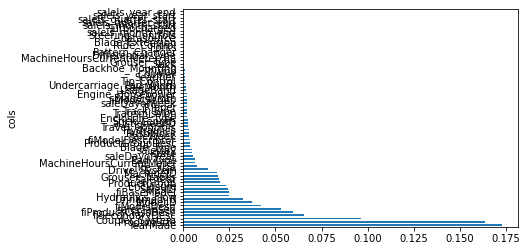

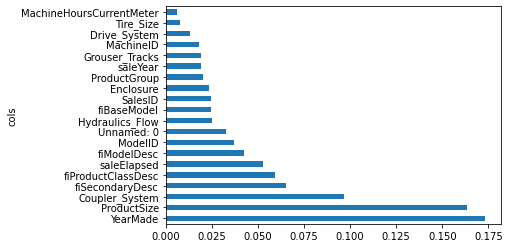

In [114]:
fi = reg.plot_feature_importance()
fi = reg.plot_feature_importance(top=20)

In [115]:
#export
@patch_to(RfRegressor)
def drop_cols_low_importance(self, tresh=0.005):
    """
    takes a datafreame and drops all columns with a feature-imporatance lower than the defined treshold.
    this dataframe can be used to create a new regressor to hopefully improve model performace
    """
    df_feat = self.feature_importance()
    cols_to_keep = df_feat[df_feat['imp']<tresh]['cols']
    cols_to_keep = [c for c in self.train_x.columns if len(self.train_x[c].unique())>1]
    self.train_x = self.train_x[cols_to_keep]
    self.val_x = self.val_x[cols_to_keep]
    
    

In [116]:
l1 = len(reg.train_x.columns)
reg.drop_cols_low_importance()
l2 = len(reg.train_x.columns)
l1,l2
assert l1 > l2
assert l2 == len(reg.val_x.columns)

# Clusert similar columns to find correlations

In [117]:
#export
@patch_to(RfRegressor)
def calc_correlations(self):
    self.corr = np.round(scipy.stats.spearmanr(self.train_x).correlation, 4)
    self.corr_cols = self.train_x.columns
    if np.isnan(self.corr[0,:]).any():
        # we sometimes get correlations with NaN if we have columns that do not match
        print('dropping nan correlations')
        to_keep = ~np.isnan(reg.corr[0,:])
        temp_x = self.train_x.columns[to_keep]
        self.corr = np.round(scipy.stats.spearmanr(temp_x).correlation, 4)
        self.corr_cols = to_keep

@patch_to(RfRegressor)
def plot_correlation_heatmap(self):
    if not hasattr(self, 'corr') or self.corr is None:
        self.calc_correlations()
        
    f=plt.gcf()
    plt.matshow(self.corr, fignum=f.number)
    plt.xticks(range(self.train_x.shape[1]), self.corr_cols, fontsize=14, rotation=90)
    plt.yticks(range(self.train_x.shape[1]), self.corr_cols, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    

In [118]:
reg.corr=None

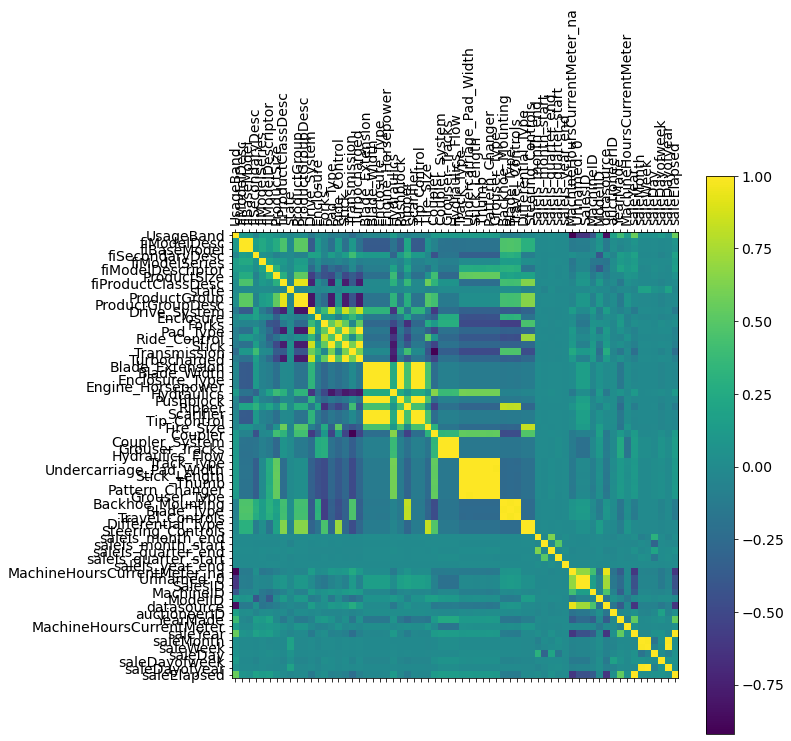

In [119]:
plt.figure(figsize=(10,10))
reg.plot_correlation_heatmap()

In [120]:
#export
@patch_to(RfRegressor)
def plot_var_linkage(self):
    if not hasattr(self, 'corr') or self.corr is None:
        self.calc_correlations()
    
    corr_condensed = hc.distance.squareform(1-self.corr)
    z = hc.linkage(corr_condensed, method='average')
    dendrogram = hc.dendrogram(z, labels=self.corr_cols, orientation='left', leaf_font_size=16)
    plt.show()

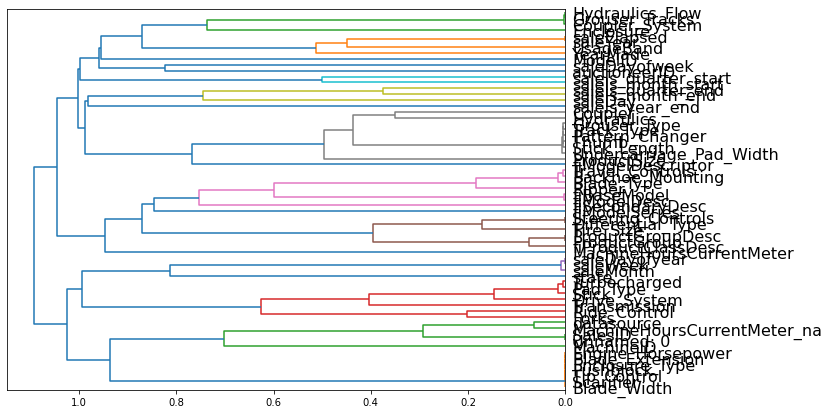

In [121]:
plt.figure(figsize=(10,7))
reg.plot_var_linkage()

In [122]:
#export
def _get_list_of_high_corr(corr, corr_limit):
    p = np.argwhere(np.triu(np.abs(corr)>corr_limit,1))
    l = list(p)
    return l
    

def _del_param_in_array(arr, value):
    for i in range(len(arr)-1,0,-1):
        if arr[i-1][0] == value:
            del arr[i-1]
                    
def _del_duplicated_columns(arr):
    i=0
    while(i<len(arr)):
        _del_param_in_array(arr,arr[i][1])
        i+=1
    return arr
    
def _arrays_to_colnames(columns,arr):
    data = dict()
    for i in range(len(arr)):
        temp = data.get(arr[i][0],list())
        if len(temp)==0:
            colname = columns[arr[i][0]]
            temp.append(colname)
        colname = columns[arr[i][1]]
        temp.append(colname)
        data[arr[i][0]]  = temp
    ret = [ data[k] for k in data.keys()]
    return ret
    
@patch_to(RfRegressor)
def get_correlation_pairs(self, corr_limit = 0.98):
    l = _get_list_of_high_corr(self.corr, corr_limit)
    _del_duplicated_columns(l)

    return _arrays_to_colnames(self.corr_cols, l)

In [123]:
pairs = reg.get_correlation_pairs()
pairs

[['fiModelDesc', 'fiBaseModel'],
 ['ProductGroup', 'ProductGroupDesc'],
 ['Pad_Type', 'Stick', 'Turbocharged'],
 ['Blade_Extension',
  'Blade_Width',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Pushblock',
  'Scarifier',
  'Tip_Control'],
 ['Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow'],
 ['Track_Type',
  'Undercarriage_Pad_Width',
  'Stick_Length',
  'Thumb',
  'Pattern_Changer',
  'Grouser_Type'],
 ['Backhoe_Mounting', 'Blade_Type', 'Travel_Controls'],
 ['Differential_Type', 'Steering_Controls'],
 ['Unnamed: 0', 'SalesID'],
 ['saleYear', 'saleElapsed'],
 ['saleMonth', 'saleWeek', 'saleDayofyear'],
 ['saleWeek', 'saleDayofyear']]

# remove redundant variables that are higly correlated

In [134]:
@patch_to(RfRegressor)
def _try_pair(self, pair, key):
    """
    Tries to remove one column at a time and train the random forest regressor to see if the error becomes smaller.
    pair: list of column names to try to remove.
    key: key to sort on to select wich columns to remove.
    """
    res = list()
    for c in pair:
        trainres = self.fit(cols_to_drop=c)
        res.append((c, trainres))
    rev=True if 'score' in key else False
    res.sort(key= lambda a: a[1][key], reverse=rev)
    print(res)
    cols = [res[i][0] for i in range(len(res)//2)]
    print(cols)
    return cols    

In [135]:
errors = reg._try_pair(pairs[1], 'val_rmse')
errors

training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 8.158063888549805
training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 8.375309944152832
[('ProductGroup', {'train_rmse': 0.12977950689751155, 'val_rmse': 0.2137302212843001, 'oob_error': 0.2015165285805373, 'oob_score': 0.9124825319029309}), ('ProductGroupDesc', {'train_rmse': 0.12985511295916877, 'val_rmse': 0.21400931094187037, 'oob_error': 0.20161236321255727, 'oob_score': 0.9123992712518232})]
['ProductGroup']


['ProductGroup']

In [136]:
errors = reg._try_pair(pairs[1], 'oob_score')

training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 8.107475996017456
training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 8.223724365234375
[('ProductGroup', {'train_rmse': 0.12976677197756034, 'val_rmse': 0.21484477386734996, 'oob_error': 0.20140313550868913, 'oob_score': 0.9125809961087451}), ('ProductGroupDesc', {'train_rmse': 0.1298305061288257, 'val_rmse': 0.21386957580097346, 'oob_error': 0.2019036572431867, 'oob_score': 0.9121459534182085})]
['ProductGroup']


In [138]:
res = reg.fit()

training


/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


finished training
training time: 8.047505140304565


In [145]:
#export
def print_result(res):
    for key in res.keys():
        print(f"{key}: {res[key]:.5f}")
        
def print_result_diff(res1, res2):
    for key in res1.keys():
        diff = res1[key] - res2[key]
        print(f"{key}: {diff:.5f}")

In [150]:

print_result(res)
print('\n')
print_result_diff(res, res)

train_rmse: 0.13041
val_rmse: 0.21445
oob_error: 0.20202
oob_score: 0.91205


train_rmse: 0.00000
val_rmse: 0.00000
oob_error: 0.00000
oob_score: 0.00000


In [146]:
print_result_diff(res, res)

train_rmse: 0.00000
val_rmse: 0.00000
oob_error: 0.00000
oob_score: 0.00000


In [156]:
@patch_to(RfRegressor)
def try_pairs(self, key='oob_error'):
    res_before = self.fit()
    print(f'{key} Before:')
    print_result(res_before)
    
    pairs = reg.get_correlation_pairs()
    cols = list()
    for pair in pairs:
        temp = reg._try_pair(pair, key)
        cols.extend(temp)
    res_after = self.fit(cols_to_drop=cols)
    print(f'{key} After:')
    print_result(res_after)
    print('\n')
    print_result_diff(res_before, res_after)

    return cols

# Result for different keys
oob_score After:
train_rmse: -0.00300
val_rmse: -0.00061
oob_error: -0.00009
oob_score: 0.00008
    
val_rmse After:
train_rmse: -0.00333
val_rmse: -0.00054
oob_error: -0.00007
oob_score: 0.00006
oob_error
training

oob_error After:
train_rmse: -0.00236
val_rmse: -0.00076
oob_error: -0.00161
oob_score: 0.00140


In [ ]:
# hur göra om det finns delar som gör att oob felet blir större?

In [158]:
def find_out_of_domain(self, tresh=0.05):
    """
    finding columns that has different distrubution between the training and validation set.
    eg, sales-id that continously grows that some numbers are in the training-set and others in the
    validation set. This is a problem because random-forests can't predict things it hasn't seen before.
    """
    df_dom = pd.concat([self.train_x, self.val_x])
    is_valid = np.array([0]*len(self.train_x) + [1]*len(self.val_x))
    self.model.fit(df_dom, is_valid)
    fi = self.feature_importance()
    res = fi[fi['imp']>tresh]
    print(res)
    
    

[0, 0, 0]

In [29]:
pairs[1]
#def remove_highly_correlat

['ProductGroup', 'ProductGroupDesc']

In [ ]:
# todo, show decision parameters. waterfall
# todo, show decision tree.
# todo, remove dependent variables.

In [92]:
self.train_x['is_valid']

[['saleDayofyear', 'saleWeek', 'saleMonth'],
 ['Track_Type',
  'Stick_Length',
  'Undercarriage_Pad_Width',
  'Thumb',
  'Grouser_Type',
  'Pattern_Changer'],
 ['Stick', 'Turbocharged'],
 ['Pushblock',
  'Blade_Width',
  'Engine_Horsepower',
  'Scarifier',
  'Blade_Extension',
  'Tip_Control',
  'Enclosure_Type'],
 ['Travel_Controls', 'Blade_Type', 'Backhoe_Mounting'],
 ['Differential_Type', 'Steering_Controls'],
 ['Tip_Control', 'Enclosure_Type']]

In [94]:
from nbdev.export import *
notebook2script()

Converted 00_regressor.ipynb.
Converted 01_cleandata.ipynb.
Converted 03_baysian_reg.ipynb.
Converted Template_rf_forest.ipynb.
Converted index.ipynb.
